In [1]:
%matplotlib inline
import os,random
from packaging import version
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import _pickle as cPickle
%load_ext tensorboard
import numpy as np
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.2.0


In [2]:
Xd = cPickle.load(open("2016.04C.multisnr.pkl",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [3]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,int(n_examples)), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [5]:
in_shp = list(X_train.shape[1:])
classes = mods
dr = 0.5 # dropout rate (%)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape(([1]+in_shp), input_shape=in_shp))
model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(tf.keras.layers.Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
model.add(tf.keras.layers.Dropout(dr))
model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(tf.keras.layers.Convolution2D(80, (2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
model.add(tf.keras.layers.Dropout(dr))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), name="dense1"))
model.add(tf.keras.layers.Dropout(dr))
model.add(tf.keras.layers.Dense( len(classes), kernel_initializer=tf.keras.initializers.he_normal(), name="dense2" ))
model.add(tf.keras.layers.Activation('softmax'))
model.add(tf.keras.layers.Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
nb_epoch = 100  
batch_size = 1024
filepath = "convmodrecnets.wts.h5"
score = model.fit(X_train, Y_train, 
                  verbose = 2, 
                  validation_data = (X_test, Y_test), 
                  epochs=100, 
                  batch_size=batch_size,
                  callbacks = [
                      
                      tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                  ]
                 )
model.load_weights(filepath)
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_4 (Dropout)          (None, 80, 1, 132)       

Overall Accuracy:  0.15256760109154055
Overall Accuracy:  0.14991398377979848
Overall Accuracy:  0.16173570019723865
Overall Accuracy:  0.1634782608695652
Overall Accuracy:  0.1833575229801645
Overall Accuracy:  0.28399311531841653
Overall Accuracy:  0.49987754102375703
Overall Accuracy:  0.6744817374136229
Overall Accuracy:  0.7760403530895335
Overall Accuracy:  0.9087546239210851
Overall Accuracy:  0.8962521717547779
Overall Accuracy:  0.896568748457171
Overall Accuracy:  0.9294575529068353
Overall Accuracy:  0.9238165680473372
Overall Accuracy:  0.8949435444280806
Overall Accuracy:  0.928923988153998
Overall Accuracy:  0.9330024813895782
Overall Accuracy:  0.9095890410958904
Overall Accuracy:  0.9184528208918453
Overall Accuracy:  0.9389940239043825


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

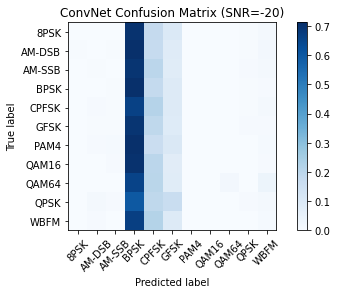

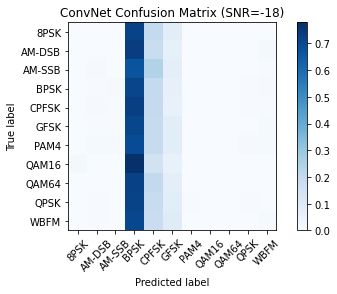

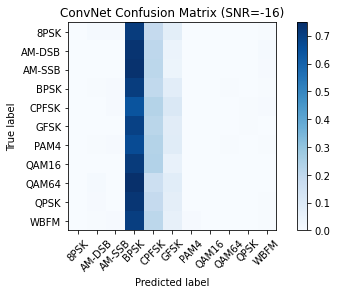

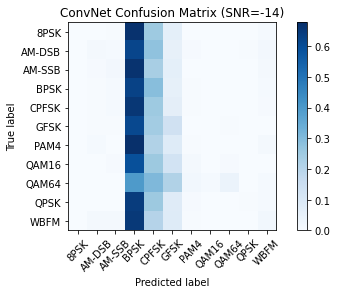

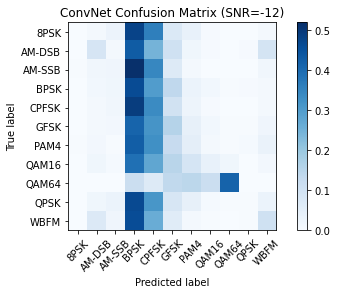

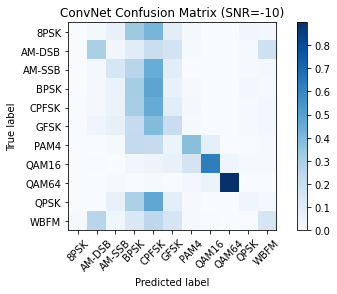

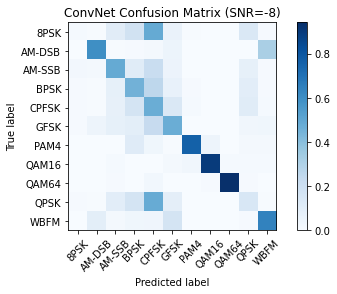

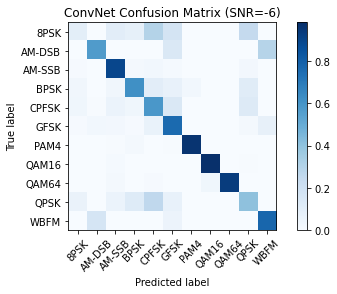

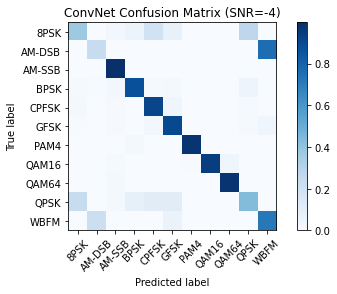

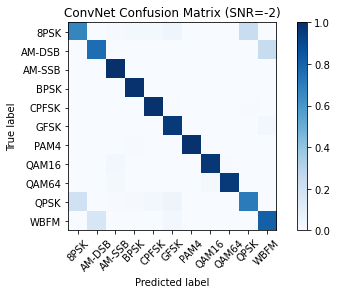

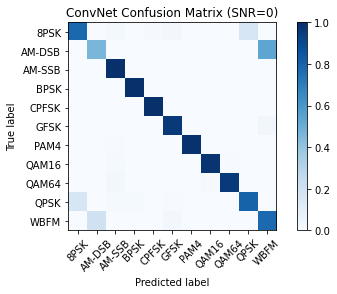

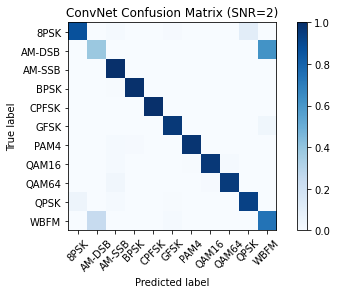

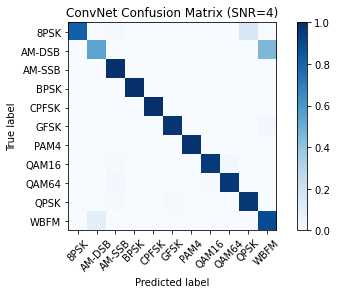

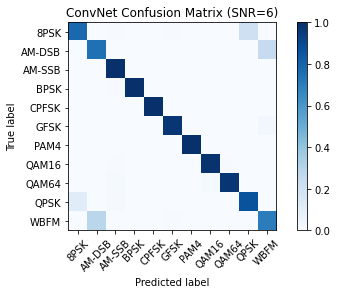

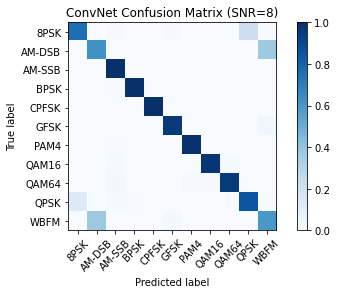

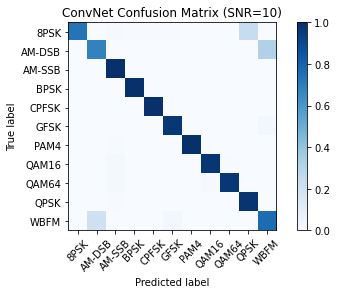

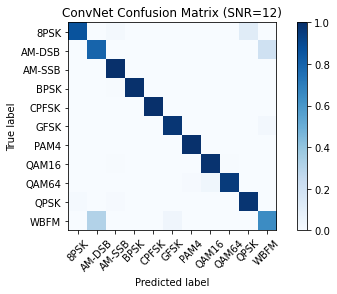

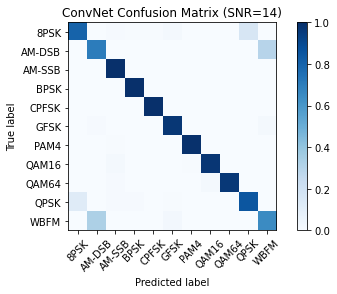

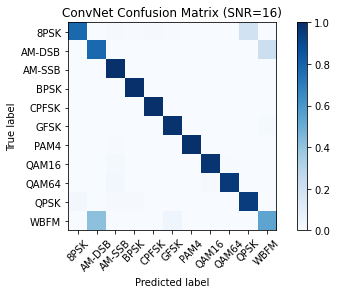

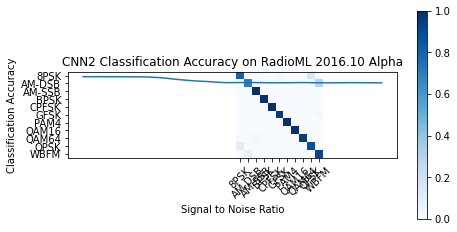

In [7]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
acc = {}
for snr in snrs:
    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
#    print(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

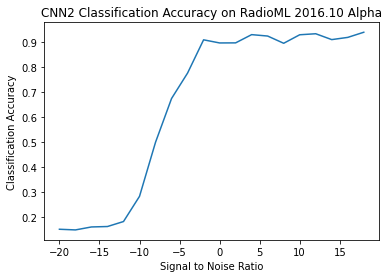

In [8]:
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

In [11]:
acc = {}
for i in snrs:
    acc[i] = []
def runner(seed):
    np.random.seed(seed)
    nb_epoch = 100  
    batch_size = 1024 
    n_examples = X.shape[0]
    n_train = n_examples * 0.5
    train_idx = np.random.choice(range(0,int(n_examples)), size=int(n_train), replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx))
    X_train = X[train_idx]
    X_test =  X[test_idx]
    def to_onehot(yy):
        yy1 = np.zeros([len(yy), max(yy)+1])
        yy1[np.arange(len(yy)),yy] = 1
        return yy1
    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))
    in_shp = list(X_train.shape[1:])
    classes = mods
    dr = 0.5 # dropout rate (%)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape(([1]+in_shp), input_shape=in_shp))
    model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
    model.add(tf.keras.layers.Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
    model.add(tf.keras.layers.Dropout(dr))
    model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
    model.add(tf.keras.layers.Convolution2D(80, (2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
    model.add(tf.keras.layers.Dropout(dr))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), name="dense1"))
    model.add(tf.keras.layers.Dropout(dr))
    model.add(tf.keras.layers.Dense( len(classes), kernel_initializer=tf.keras.initializers.he_normal(), name="dense2" ))
    model.add(tf.keras.layers.Activation('softmax'))
    model.add(tf.keras.layers.Reshape([len(classes)]))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
#     model.summary()
    filepath = "convmodrecnets_CNN2_0.5.wts_%d.h5"%(seed)
    score = model.fit(X_train, Y_train, 
                      verbose = 2, 
                      validation_data = (X_test, Y_test), 
                      epochs=100, 
                      batch_size=batch_size,
                      callbacks = [
                          tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                          tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                      ]
                     )
    model.load_weights(filepath)
    for snr in snrs:
        # extract classes @ SNR
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    #    print(test_SNRs)
        test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes),len(classes)])
        confnorm = np.zeros([len(classes),len(classes)])
        for i in range(0,test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
#         plt.figure()
#         plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        accuracy = cor / (cor+ncor)
        print ("Overall Accuracy: ", accuracy)
        acc[snr].append(accuracy)

for i in [1947, 1971, 1977, 1999, 2020]:
    runner(i)

Epoch 1/100
80/80 - 4s - loss: 2.3827 - val_loss: 1.9501
Epoch 2/100
80/80 - 4s - loss: 1.7295 - val_loss: 1.4617
Epoch 3/100
80/80 - 4s - loss: 1.4402 - val_loss: 1.2498
Epoch 4/100
80/80 - 4s - loss: 1.3018 - val_loss: 1.1697
Epoch 5/100
80/80 - 4s - loss: 1.2389 - val_loss: 1.1410
Epoch 6/100
80/80 - 4s - loss: 1.2042 - val_loss: 1.1122
Epoch 7/100
80/80 - 4s - loss: 1.1818 - val_loss: 1.0955
Epoch 8/100
80/80 - 4s - loss: 1.1508 - val_loss: 1.0656
Epoch 9/100
80/80 - 4s - loss: 1.1264 - val_loss: 1.0354
Epoch 10/100
80/80 - 4s - loss: 1.0929 - val_loss: 1.0272
Epoch 11/100
80/80 - 4s - loss: 1.0725 - val_loss: 1.0124
Epoch 12/100
80/80 - 4s - loss: 1.0570 - val_loss: 0.9984
Epoch 13/100
80/80 - 4s - loss: 1.0446 - val_loss: 0.9878
Epoch 14/100
80/80 - 4s - loss: 1.0359 - val_loss: 0.9829
Epoch 15/100
80/80 - 4s - loss: 1.0256 - val_loss: 0.9795
Epoch 16/100
80/80 - 4s - loss: 1.0152 - val_loss: 0.9683
Epoch 17/100
80/80 - 4s - loss: 1.0104 - val_loss: 0.9688
Epoch 18/100
80/80 - 4s

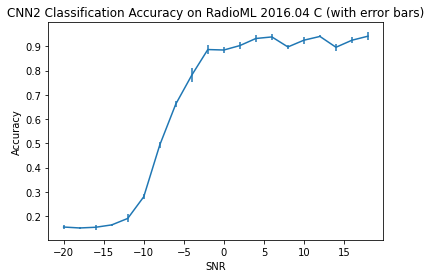

In [12]:
import matplotlib.pyplot as plt
yerr = []
y = []
x = []
for i in acc:
    yerr.append(np.std(acc[i]))
    y.append(np.mean(acc[i]))
    x.append(i)
# plt.errorbar(x, y, yerr, linestyle='solid', marker='^')
fig, ax = plt.subplots()
ax.errorbar(x, y,
            yerr=yerr,
            fmt='-')

ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('CNN2 Classification Accuracy on RadioML 2016.04 C (with error bars)')
plt.show()

In [19]:
mean = []
for i in acc:
    mean.append(np.mean(acc[i]))
print(np.mean(mean)*100)
##Average accuracy (87.4 in the paper)

65.5036989484602
